## Index  
1) [Importing Liabraries](#Section_0)  
Q1) [Analysis of Problem and some recommendation about the methods we can use](#Section_1)  
 >   a)  [nan Value](#Section_1_1)  
 >   b)  [Explore Data](#Section_1_2)  
 >   c)  [Approch we can use to solve recommendation system](#Section_1_3)
 
Q2) [Descision on above mentioned approach](#Section_2)    
Q3) [Recommendation System](#section_3)  
>    a) [Preprocessing of data](#Section_3_1)  
>    b) [Create Test data](#Section_3_8)  
>    c) [We will apply collaborative filtering to our dataset. ( From Scratch)](#Section_3_2)   
>    d) [Training of model](#Section_3_3)  
>    e) [Load the model from csv](#Section_3_4)  
>    f) [user whose interest are similar](#Section_3_5)  
>    g) [Probable similar content](#Section_3_6)  
>    h) [Let's make hands dirty, and give recommendation to given user](#Section_3_7)  

Q4) [Features and descision taken while deriving the model](#Section_4)    
Q5) [How to scale the model](#Section_5)  
Q6) [Representation of relation between user's, content's](#Section_6)  
- [Reference](#Reference)

## Import Liabraries  
<a class="anchor" id="Section_0"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sn
import random
import plotly.express as px
import plotly.graph_objects as go

In [2]:
base_dir = r'C:\Users\Gaurav Ramse\Desktop\Sem_3\Docebo/'
dataset_name = 'dataset-Assignment-DataScientist.csv'

In [3]:
df = pd.read_csv(base_dir + dataset_name)

In [4]:
df.shape

(57179, 6)

In [5]:
df.head()

,content,content_created,is_private,duration,idUser,viewed
0,29,2013-11-15 14:00:31,1.0,NaN,13580,2015-12-08 12:36:40
1,CS_1320,2018-04-10 15:17:01,0.0,NaN,13929,2018-04-10 17:44:24
2,CS_1285,2018-03-26 17:33:26,0.0,0.0,13903,2018-04-19 17:59:32
3,CS_1395,2018-05-15 21:01:01,0.0,0.0,13912,2018-05-16 23:12:07
4,99,2016-11-24 12:32:03,1.0,NaN,13830,2017-07-20 17:37:53


## Q-1) Analysis of the problem and its solution space  
<a id="Section_1"></a>

First let's explore our data and find ratio of formal and informal courses.  
Informal courses start with CS,  Formal courses start without CS.   


In [6]:
print(f" We have {len(df['idUser'].unique())} unique user")
print(f" We have {len(df['content'].unique())} unique courses")

 We have 267 unique user
 We have 801 unique courses


### a) Nan value  
<a id="Section_1_1"></a>

In [7]:
# Let's see how many Nan value in each columns
df.isna().sum()

content                2
content_created        2
is_private             2
duration           31293
idUser                 0
viewed               816
dtype: int64

In [8]:
# as we have no content information that user watched, So we will drop that rows
df[df.drop((['duration','viewed']), axis = 1).isnull().any(axis=1)]

,content,content_created,is_private,duration,idUser,viewed
27779,NaN,NaN,NaN,NaN,12363,2013-06-17 08:25:34
48019,NaN,NaN,NaN,NaN,12363,2013-06-17 09:22:09


In [9]:
# Dropping 2 rows which is not required for analysis as we don't have content name there.
df.dropna(subset = ['content','content_created'], inplace=True)

### b) Explore data  
<a id="Section_1_2"></a>

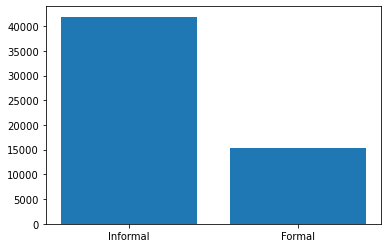

In [10]:
# calculate informal courses and formal courses
temp_df = df['content'].str.startswith('CS').value_counts().to_frame()
plt.bar(x = ['Informal', 'Formal'],height =temp_df['content'] )
plt.show()

In [11]:
# From these value it seems that we informal courses are not revieling there course duration, Or data entry for 
# this column was not done.  

print( f"Nan value in the duration column for informal courses is, {df[df['content'].str.startswith('CS')]['duration'].isna().sum()}" )
print( f"No of informal couses with zero value are, {df[df['content'].str.startswith('CS')]['duration'].value_counts()[0]}")

Nan value in the duration column for informal courses is, 16007
No of informal couses with zero value are, 22759


Now we will create features that may be useful for recommender system.  
1) Time difference between released and viewed,     
> As this is learning platform, Technology is changing really fast so usually people prefer to see the latest content, which is upgraded. So we will create feature with the difference in time of release and viewed time. There is possibility that user is watching some latest content.    

2) Duration,    
>Duration is important parameter as per research top 250 moviews on netfix with duration greated that 45 min, But in our 
    data we see that most of the courses with zero value and nan values. I don't want to loose information from this column.
    It is most likely to user prefer some time length of courses, So my approach is to take avg duration for user anf fill those
    values corresponding to user.  
    But for now i will fill nan value to zero
    
3) IsPrivate,  
> We will keep this column as it is, as we have deleted nan value fom that  

In [12]:
### 1) Time difference between released and viewed

# We have 816 nan value in viewed so that , We will replace nan value, assuming user watched course on the same day.

In [13]:
df['viewed'].fillna(df['content_created'], inplace=True)

In [14]:
df['Time difference between released and viewed'] = (pd.to_datetime(df['viewed'])- pd.to_datetime(df['content_created'])).dt.days

In [15]:
### 2) Duration, For now we will update with 0
df.fillna(value = {'duration':0}, inplace=True)

In [16]:
df.isna().sum()

content                                        0
content_created                                0
is_private                                     0
duration                                       0
idUser                                         0
viewed                                         0
Time difference between released and viewed    0
dtype: int64

In [17]:
# Okay so Let's check duplicate entry in the dataset- 
# e found duplicated entry So let's try to transform this df and try to see the data.
z = df[df.duplicated(["content","content_created", "idUser"])]

# z[(z['content']=='CS_1302') &(z['idUser']==13096)]

z.groupby(['idUser', 'content']).agg(avg_value = ('Time difference between released and viewed','mean'),
                                    duration = ('duration', 'sum')).reset_index()

,idUser,content,avg_value,duration
0,12361,1,184.0,0.0
1,12361,CS_724,20.0,0.0
2,12361,CS_803,0.0,0.0
3,12361,CS_98,0.0,0.0
4,12362,1,71.0,0.0
...,...,...,...,...
5533,13977,87,585.0,0.0
5534,13977,88,585.0,0.0
5535,13977,89,586.0,0.0
5536,13977,90,586.0,0.0


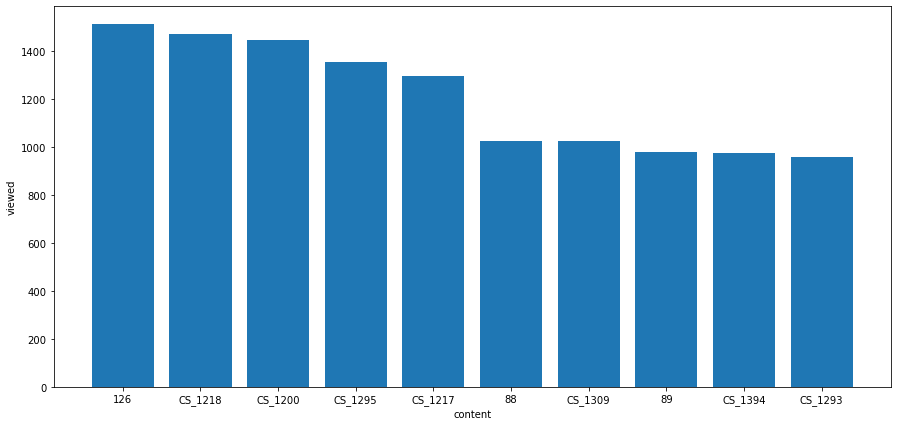

In [69]:
# Let's see how many times content was viewed for particular content,( As i have tried to plot this with plotly This diagram
# will not visible, for that i have attached two images )
temp_df = df.groupby((['content']))['viewed'].count().sort_values(ascending=False).head(10).to_frame().reset_index()
plt.figure(figsize = (15, 7))
plt.bar(x=temp_df['content'], height=temp_df['viewed'],  )
plt.xlabel('content')
plt.ylabel('viewed')
plt.show()


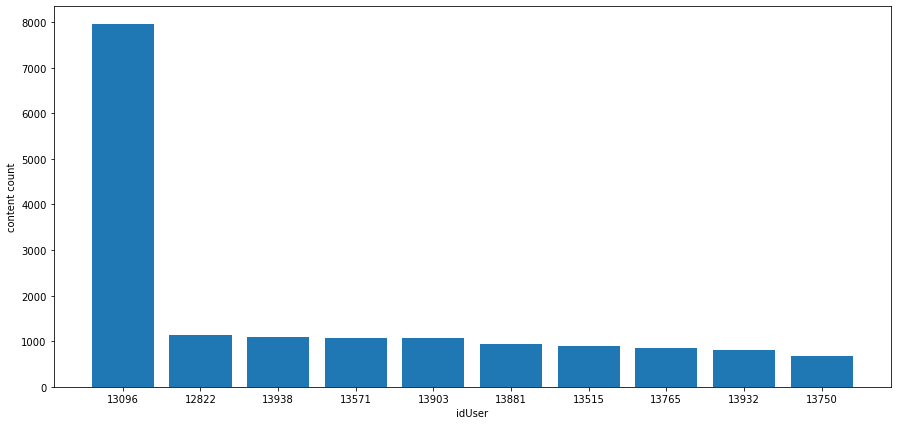

In [68]:
# Let's see how many times user viewed content
temp_df = df.groupby((['idUser']))['content'].count().sort_values(ascending=False).head(10).to_frame().reset_index()
temp_df['idUser'] = temp_df['idUser'].astype('str')
plt.figure(figsize = (15, 7))
plt.bar(x=temp_df['idUser'], height=temp_df['content'],  )
plt.xlabel('idUser')
plt.ylabel('content count')
plt.show()

In [20]:
# Let's create machine learning df
ml_df = df.groupby((['idUser', 'content'])).agg(avg_value = ('Time difference between released and viewed','mean'),
                                    duration = ('duration', 'sum'), count = ('is_private', 'count')).reset_index()

In [21]:
# I am assuming these as my features, where,
#  avg_value :- denote mean of time difference between release and viewed
#  duration  :- denote sum of duration for that content by that user
#  count     :- How many time user watched particular content/
ml_df

,idUser,content,avg_value,duration,count
0,12361,1,184.166667,0.0,6
1,12361,43,0.000000,0.0,1
2,12361,45,0.000000,0.0,1
3,12361,56,146.000000,0.0,1
4,12361,57,0.000000,0.0,2
...,...,...,...,...,...
13760,13977,88,585.000000,0.0,8
13761,13977,89,586.000000,0.0,8
13762,13977,90,586.000000,0.0,4
13763,13977,91,586.000000,0.0,1


In [22]:
# from sklearn.model_selection import train_test_split
# train_df, test_df = train_test_split(ml_df, test_size=0.25)

### c) Approch we can use to solve recommendation system   
<a id="Section_1_3"></a>

Possible approaches we can use to solve the recommendation system we want to make. 
1) Content filtering:-  
 Content filtering is technique where we solve the recommendation system problem using features available for the data,  
     like in our data there are some features like duration , isprivate, time of released and , viewed time. This method is      useful when we have quality features available. This type of recommendation system work well when any new user come to website.    
     
>    Pros: - i) As we know about some features about the user like geolocation, trending content and we can recommend at cold start.  
ii) We don't need any features from other user.  
iii) Able to recommend unpopular and old items.  
iv) With this we can know why we have recommended particular item. 


>    Cons:- i) We always want some features of content. It's really hard to get feature of each content.   
ii) It will never recommend item outside of interest of user, It will just stick to user interest.  
 
2) Collaborative filtering:-  

Now in this collaborative filtering we don't want any features to be selected, So i decided to work with this technique.  
There was some features with which i can work but those were nan values more than 50% in duration column and other features were not giving much information about content. So idecided to extract count of particular user watching particular content and then I treated as 1-15 rating. Also i mentioned in the code reason behind of this descision.  

>  Pros: - i) It will work with various variety of problem, It recommend outside of user interest content too.  


> cons:-  i) We are getting sparse matrix which , In our problem we have really small matrix, But in really world problem it can create some computational issue.  
ii) It need to deal with cold start problem that's why some of companies like netflix, amazon ask some initial data about our interest.  


## Q2.  Make a decision on one of the aforementioned approaches and motivate that decision.  
<a id="Section_2"></a>
As mentioned above, I don't see useful feature in the dataset required for this problem. Also considering the prons and cons I selected this type of recommendation.  

## Q3. Recommendation System  
<a id="Section_3"></a>

### a) Preprocessing of Data.  
<a id="Section_3_1"></a>

In [23]:
# We will create dataframe with user as columns and content as a index
create_df = pd.DataFrame(index = df['content'].unique(), columns = df['idUser'].unique())

In [24]:
# Here i want to check , How many times particular ount was seen,
# So from the result of this cell, Keys of this dictionary represent how many times user cviewed the content, and values  
# represent the count of that.
count_columns_with_corresponding_count_value = dict(ml_df['count'].value_counts().sort_values(ascending=False).head(15))
count_columns_with_corresponding_count_value

{1: 6038,
 2: 2504,
 3: 1722,
 4: 749,
 8: 618,
 7: 528,
 5: 437,
 6: 322,
 9: 144,
 10: 103,
 11: 72,
 12: 63,
 13: 55,
 15: 49,
 14: 45}

In [25]:
# In above df we have count column, which we will scale from 1-15.
# I will do if user watched more than 15 times then i will give value 15 else we will scale that between 0-5
print(f'Max value in count columns {ml_df["count"].max()}')
print(f'Max value in count columns {ml_df["count"].min()}')

Max value in count columns 928
Max value in count columns 1


In [26]:
def change_scale(x, count_columns_with_corresponding_count_value):
    if x in count_columns_with_corresponding_count_value:
        return x
    else:
        return 15
        

ml_df['count'] = ml_df['count'].apply(lambda x: change_scale(x, count_columns_with_corresponding_count_value.keys()))


# test_df['count'] = test_df['count'].apply(lambda x: change_scale(x, count_columns_with_corresponding_count_value.keys()))

In [27]:
# Let's check the max and min value, Perfect we are ready to create df
print(f'Max value in count columns {ml_df["count"].max()}')
print(f'Max value in count columns {ml_df["count"].min()}')

Max value in count columns 15
Max value in count columns 1


In [28]:
for i in tqdm(ml_df.to_numpy()):
    create_df.loc[i[1],i[0]] = i[4]
    
# for i in tqdm(test_df.to_numpy()):
#     create_df_test.loc[i[1],i[0]] = i[4]
    

100%|██████████████████████████████████████████████████████████████████████████| 13765/13765 [00:03<00:00, 3475.58it/s]


In [29]:
# We have filled the create_df with count column to particular cell position
create_df.head()

,13580,13929,13903,13912,13830,12368,13454,13735,13774,13862,...,13820,13930,13566,13924,13899,12366,13725,13856,13751,13678
29,2,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CS_1320,1,10,15,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CS_1285,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CS_1395,3,7,5,1,NaN,9,NaN,3,NaN,1,...,NaN,1,NaN,1,1,NaN,NaN,NaN,NaN,NaN
99,NaN,3,3,NaN,3,NaN,NaN,3,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### b) Creating test data  
<a id="Section_3_8"></a>

In [30]:
# Getting random co-ordinate from create_df where values are not null
test_row_column = np.argwhere(create_df.notnull().values).tolist()  

In [31]:
# We are considering 3000 cell as a test data
random_index = random.sample(list(test_row_column), 3000, )

In [32]:
# here we have replaced some value in create_df to nan , So that we can treat this as our test dataset and calculate loss
value_at_those_random_index = []
for i in random_index:
    value_at_those_random_index.append(create_df.iloc[i[0],i[1] ])
    create_df.iloc[i[0],i[1] ] = np.nan

In [33]:
# We will create array where each cell will represent [x_co-rdinate, y_coordinate, value at that co ordinate] 
b = np.array(value_at_those_random_index).reshape(-1, 1)
a = np.array(random_index)

random_index_val = np.concatenate((a, b), axis=1)

In [34]:
random_index_val

array([[368,  95,   2],
       [ 16, 111,   2],
       [232, 251,   1],
       ...,
       [295,  14,   3],
       [278, 112,   2],
       [149,  45,   3]])

In [35]:
# Let's check if we replaced 3000 values to nan, Yesss , We have replaced that with nan.Great 
len(np.argwhere(create_df.notnull().values).tolist())

10765

### c) We will apply collaborative filtering to our dataset. ( From Scratch)  
<a id="Section_3_2"></a>
We are assignimg feature matrix to represent content and theta matrix to represent user.  
Simple representation of what i am trying to do  

$\theta$ = Feature of each user having dimension equal to (no of user, features we defined)   
x = Features of each content having dimension equal to (no of content, features we defined)  

So we will use Gradient descent , derivative of loss with respect to $\theta$ and $X$  

Algorithm-   
Step -1  -: Initializtion of $\theta$, $X$, Leraning rate for both    
Step -2  -: Gradient Descent on $\theta$, $X$.  
Step- 3 - : Repeat Step 1, 2 until convergence.  


$\theta_{i+1} = \theta_{i} - \alpha_{\theta} * \sum \theta_{i}^{T}.X - y_{Actual}$  
$X_{i+1} = X_{i} - \alpha_{X} * \sum \theta^{T}.X_{i} - y_{Actual}$

In [36]:
# In this function i will using gradient descent to theta and by taking derivative of loss function w.r.t theta.

def update_theta(dff, no_of_user, no_of_content, theta, x, lr_theta):
#     l = []
    for j in range(no_of_user):
        temp_theta = []
        for i in range(no_of_content):
            temp_y = dff.iloc[i, j]

            if not pd.isna(temp_y):
                y_pred = theta[j].dot(x[i].T)
                temp_theta.append(list((y_pred - temp_y)* x[i]))

#                 l = l + np.square(theta[j].dot(x[i].T) - temp_y)
            #         else:
            #             print(f'skip {i}')
        #         print(temp_theta)
        theta[j] = theta[j] - lr_theta *np.sum(np.array(temp_theta), axis = 0)
    return theta

# In this function i will using gradient descent to x and by taking derivative of loss function w.r.t. x.
def update_x(dff, no_of_user, no_of_content, theta, x, lr_x):
    l=0
    count = 0
    for i in range(no_of_content):
        temp_x = []
        
        for j in range(no_of_user):
            temp_y = dff.iloc[i, j]

            if not pd.isna(temp_y):
                y_pred = theta[j].dot(x[i].T)
#                 temp_x.append(list((theta[j].dot(x[i].T) - temp_y)* theta[j]))
                temp_x.append(list((y_pred - temp_y)* theta[j]))
                l = l + np.square(y_pred - temp_y)
                count += 1

        x[i] = x[i] - lr_x *np.sum(np.array(temp_x), axis = 0)
        
    return x, l/count

In [37]:
def calculate_loss(dff, co_ordinate_of_df, theta, x):
    l=0
    count = 0
    for co_ordinate in co_ordinate_of_df:
        temp_y = co_ordinate[2]
        j = co_ordinate[1]
        i = co_ordinate[0]
#         if not pd.isna(temp_y):

#             temp_x.append(list((theta[j].dot(x[i].T) - temp_y)* theta[j]))

        l = l + np.square(theta[j].dot(x[i].T) - temp_y)
        count +=1
    return l/count

In [38]:
no_of_user = ml_df['idUser'].nunique()
no_of_content = ml_df['content'].nunique()

In [39]:
# Initialization 
x = np.random.randn(no_of_content,4) *0.1
theta = np.random.randn(no_of_user,4) *0.1
lr_theta = 0.005
lr_x = 0.005

In [40]:
x.shape, theta.shape

((800, 4), (267, 4))

### d) Training of Model    
<a id="Section_3_3"></a>

In [41]:
# I executed for 250 epochs and finally i got 33923 as squared loss, So mean squared loss will be 33923/13765 = 2.46


train_loss = []
test_loss = []
for idx, _ in enumerate(range(10)):
    theta = update_theta(create_df, no_of_user, no_of_content, theta, x, lr_theta)
    x ,train_l= update_x(create_df, no_of_user, no_of_content, theta, x, lr_x)
    test_l = calculate_loss(create_df, random_index_val, theta, x)
    train_loss.append(train_l)
    test_loss.append(test_l)
    print(f'Epoch {idx+1} Train Loss {train_l} Test_loss {test_l}' )

Epoch 1 Train Loss 19.68637677598242 Test_loss 19.811558622621707
Epoch 2 Train Loss 19.62552919501649 Test_loss 19.668493334674466
Epoch 3 Train Loss 19.07594120930174 Test_loss 18.096465744301014
Epoch 4 Train Loss 14.489325431205202 Test_loss 10.262539652217683
Epoch 5 Train Loss 8.212788387322458 Test_loss 7.897649675621301
Epoch 6 Train Loss 6.785904539375454 Test_loss 6.860960658271022
Epoch 7 Train Loss 6.1455472714855 Test_loss 6.582500180318299
Epoch 8 Train Loss 5.757233059048579 Test_loss 6.2193019473632045
Epoch 9 Train Loss 5.52814030156232 Test_loss 6.2693218642900215
Epoch 10 Train Loss 5.332277250111969 Test_loss 6.347721515404984


In [42]:
for idx, _ in enumerate(range(10, 20)):
    theta = update_theta(create_df, no_of_user, no_of_content, theta, x, lr_theta)
    x ,train_l= update_x(create_df, no_of_user, no_of_content, theta, x, lr_x)
    test_l = calculate_loss(create_df, random_index_val, theta, x)
    train_loss.append(train_l)
    test_loss.append(test_l)
    print(f'Epoch {_+1} Train Loss {train_l} Test_loss {test_l}' )

Epoch 11 Train Loss 5.320418765177086 Test_loss 5.844639044861657
Epoch 12 Train Loss 4.661926008637081 Test_loss 5.6079902163110384
Epoch 13 Train Loss 4.3867009923097715 Test_loss 5.237115273492889
Epoch 14 Train Loss 3.9746482108571755 Test_loss 5.167275949015301
Epoch 15 Train Loss 3.8117198867156628 Test_loss 4.966272514682624
Epoch 16 Train Loss 3.695408267491879 Test_loss 5.180005158029545
Epoch 17 Train Loss 3.7652886791603115 Test_loss 5.066844026349338
Epoch 18 Train Loss 3.98220312917747 Test_loss 5.847096444527009
Epoch 19 Train Loss 4.241386532529276 Test_loss 5.652074055665967
Epoch 20 Train Loss 4.605982702434515 Test_loss 7.137930500819194


In [43]:
for idx, _ in enumerate(range(20, 40)):
    theta = update_theta(create_df, no_of_user, no_of_content, theta, x, lr_theta)
    x ,train_l= update_x(create_df, no_of_user, no_of_content, theta, x, lr_x)
    test_l = calculate_loss(create_df, random_index_val, theta, x)
    train_loss.append(train_l)
    test_loss.append(test_l)
    print(f'Epoch {_+1} Train Loss {train_l} Test_loss {test_l}' )

Epoch 21 Train Loss 4.788367984235519 Test_loss 5.984855539557291
Epoch 22 Train Loss 4.591734264965904 Test_loss 7.052138383175382
Epoch 23 Train Loss 4.41170236499495 Test_loss 5.75360756696072
Epoch 24 Train Loss 4.157718674553831 Test_loss 6.569270502659562
Epoch 25 Train Loss 4.043787329492829 Test_loss 5.59298602665967
Epoch 26 Train Loss 3.9170454247856354 Test_loss 6.298636112487025
Epoch 27 Train Loss 3.8882531338033095 Test_loss 5.558620824114446
Epoch 28 Train Loss 3.8483622345174426 Test_loss 6.254065375835562
Epoch 29 Train Loss 3.8448009723383985 Test_loss 5.619465626716445
Epoch 30 Train Loss 3.868917792024242 Test_loss 6.309331553181791
Epoch 31 Train Loss 3.87029405831152 Test_loss 5.715269721880161
Epoch 32 Train Loss 3.9160145211481576 Test_loss 6.362723821543252
Epoch 33 Train Loss 3.88929687586149 Test_loss 5.785944005479659
Epoch 34 Train Loss 3.9270957436173823 Test_loss 6.377944379427288
Epoch 35 Train Loss 3.8587954460567437 Test_loss 5.805154149275458
Epoch 36

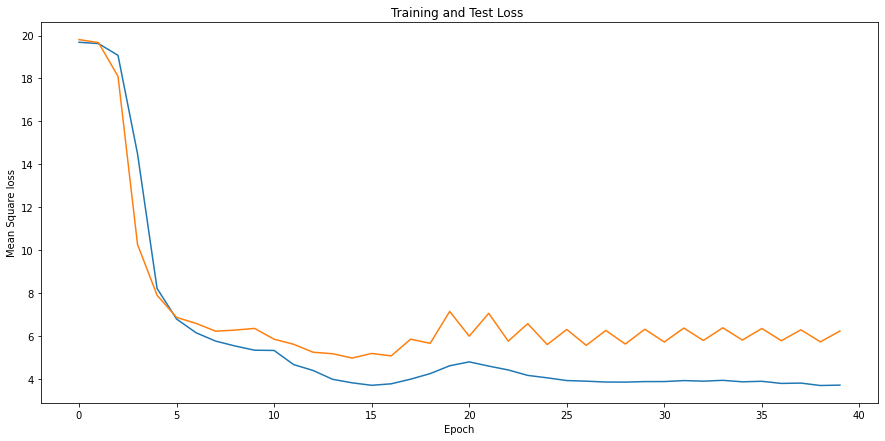

In [62]:
# So as we can see this figure, We can stop the training model at epoch 15 as there is no change in loss with number of epochs,
# But for now I have trained this model until 40 epochs where training loss decreased compare at epoch 15, 
# but test loss is almost similar
plt.figure(figsize = (15,7))
plt.plot(train_loss, label='Test Loss')
plt.plot(test_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Square loss')
plt.title('Training and Test Loss ')
plt.show()

In [44]:
# PLot of loss with respect to epoch
# This is with plotly, Which gives interactive plot so easy to analyze

fig = go.Figure()

fig.add_trace(
    go.Scatter(
       x=list(range(40)), y=train_loss,name = 'Train loss'
    ))

fig.add_trace(
    go.Scatter(
       x=list(range(40)), y=test_loss, name = 'Test loss'
    ))

fig.update_layout(xaxis_title='Epoch',
                   yaxis_title='Mean Square error',
                 title= 'Mean Squared error Vs epochs')
fig.show()


In [45]:
# Okay, Cool . Now I have value of x and theta matrix, Now i can predict for any user and content pair

In [46]:
# Now we will create the df in which we have predicted value of count.
df_recommendation = pd.DataFrame(x.dot(theta.T), index = df['content'].unique(), columns = df['idUser'].unique())
df_recommendation

,13580,13929,13903,13912,13830,12368,13454,13735,13774,13862,...,13820,13930,13566,13924,13899,12366,13725,13856,13751,13678
29,1.912463,1.872852,0.757933,1.908907,1.815770,1.717744,1.790834,0.864771,1.840792,2.119133,...,1.615354,0.784634,0.764117,1.042344,0.412441,1.758147,1.337034,1.432245,0.155935,0.248952
CS_1320,1.109225,3.832714,9.665217,6.024963,1.823332,5.756903,0.782163,4.773254,0.442550,-0.027589,...,0.583908,1.733889,1.635872,0.872627,1.351178,1.592694,-0.658722,0.918049,0.552783,0.957772
CS_1285,6.112684,5.847890,7.105921,11.736896,3.170207,-0.792439,4.720596,10.425315,3.661166,4.247937,...,3.870311,3.297024,2.740073,3.995588,1.540397,3.777997,2.878926,3.628296,0.365719,1.340627
CS_1395,1.899416,6.767870,7.996662,-0.670103,3.120608,8.534900,0.443633,5.489125,2.047873,1.288864,...,2.189278,1.008945,1.188942,1.046547,1.063451,3.201226,0.015819,1.694257,1.369224,0.815682
99,3.045093,3.107958,1.882044,3.526738,2.641804,2.238936,2.699685,2.330591,2.701396,3.082272,...,2.453662,1.332310,1.253517,1.730143,0.693470,2.642581,1.945085,2.185378,0.270525,0.467959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,0.135939,0.107247,0.201930,0.397654,0.240257,0.430479,0.218960,-0.178530,0.169927,0.205880,...,0.115425,0.108955,0.112581,0.064898,0.073410,0.178594,0.111023,0.137236,-0.007894,0.028401
CS_749,-0.164170,0.057704,0.479725,0.002527,-0.051179,0.315433,-0.166514,0.098751,-0.154756,-0.222181,...,-0.131113,-0.002735,0.004493,-0.084805,0.033662,-0.069813,-0.190190,-0.098672,0.029520,0.023646
CS_1082,0.067942,0.242295,0.641236,0.427269,0.205475,0.613087,0.101880,0.095769,0.074510,0.053589,...,0.053713,0.125181,0.128418,0.040870,0.105442,0.152785,-0.020695,0.086849,0.030403,0.059951
CS_994,0.538693,0.519298,0.173723,0.478866,0.334975,0.005036,0.404372,0.637870,0.422123,0.483805,...,0.415690,0.195179,0.170352,0.319814,0.080319,0.389886,0.331526,0.344967,0.050119,0.072680


In [47]:
df_recommendation.to_csv('Final_recommendation_array.csv', index=True)

### e) Reload the saved model  
<a id="Section_3_4"></a>

In [48]:
df_recommendation = pd.read_csv('Final_recommendation_array.csv', index_col = 'Unnamed: 0')
df_recommendation.head()

,13580,13929,13903,13912,13830,12368,13454,13735,13774,13862,...,13820,13930,13566,13924,13899,12366,13725,13856,13751,13678
29,1.912463,1.872852,0.757933,1.908907,1.815770,1.717744,1.790834,0.864771,1.840792,2.119133,...,1.615354,0.784634,0.764117,1.042344,0.412441,1.758147,1.337034,1.432245,0.155935,0.248952
CS_1320,1.109225,3.832714,9.665217,6.024963,1.823332,5.756903,0.782163,4.773254,0.442550,-0.027589,...,0.583908,1.733889,1.635872,0.872627,1.351178,1.592694,-0.658722,0.918049,0.552783,0.957772
CS_1285,6.112684,5.847890,7.105921,11.736896,3.170207,-0.792439,4.720596,10.425315,3.661166,4.247937,...,3.870311,3.297024,2.740073,3.995588,1.540397,3.777997,2.878926,3.628296,0.365719,1.340627
CS_1395,1.899416,6.767870,7.996662,-0.670103,3.120608,8.534900,0.443633,5.489125,2.047873,1.288864,...,2.189278,1.008945,1.188942,1.046547,1.063451,3.201226,0.015819,1.694257,1.369224,0.815682
99,3.045093,3.107958,1.882044,3.526738,2.641804,2.238936,2.699685,2.330591,2.701396,3.082272,...,2.453662,1.332310,1.253517,1.730143,0.693470,2.642581,1.945085,2.185378,0.270525,0.467959


In [49]:
# Let's check the min and max value predicted by our model
print(f'Max value in df_recommendation {np.max(df_recommendation.to_numpy())}')
print(f'Max value in df_recommendation {np.min(df_recommendation.to_numpy())}')


## Predicted Value should be between 0 - 15, as we have cap the value to 15, Not so bad pred max value almost 15, 
# but min value is -1.8,Which concerns me.
# I don't have access to the real data about course to see is two courses are close to each other base on this.
# But, -ve value we can assume that user don't want to see the course, Also as we have executed for 200 epochs.

Max value in df_recommendation 40.0804510374392
Max value in df_recommendation -12.422645509452352


### f) user whose interest are similar  
<a id="Section_3_5" ></a>  
 We will have distance between two user using similarity score between two vectors we just calculates, There are different similarity functions available, We can also use cosine similarity for this task
 
$\large similarity(a, b) = \frac {\sum (r_{a,c} -r_{a\_mean}) (r_{b,c} -r_{b\_mean})}{(\sqrt{\sum (r_{a,c} -r_{a\_mean})^2})(\sqrt{\sum (r_{b,c} -r_{b\_mean})^2})} $

In [50]:
users = list(df_recommendation.columns)
content = list(df_recommendation.index)


In [51]:
def similarity_between_two_vector(array_a, array_b):
    mean_a = np.mean(array_a)
    mean_b = np.mean(array_b)
    num = np.sum((array_a - mean_a)*(array_b - mean_b))

    den = np.sqrt(np.sum(np.square(array_a - mean_a))) * np.sqrt(np.sum(np.square(array_b - mean_b)))
    
    return num/den

In [52]:
def get_similar_user_df(username, users, how_many_similar_useryou_want= 20):

    array_a = df_recommendation.loc[:, username].to_numpy()
    similarity_score_list = []
    for user in users:
        array_b = df_recommendation.loc[:, user].to_numpy()
        similarity_score = similarity_between_two_vector(array_a, array_b)
        similarity_score_list.append(similarity_score)

    similarity_df = pd.DataFrame()
    similarity_df['User'] = users
    similarity_df['Similarity_score'] = similarity_score_list
    return similarity_df.sort_values(by = 'Similarity_score', ascending=False).head(how_many_similar_useryou_want)

In [53]:
username = 13580
username = str(username)
get_similar_user_df(username, users, how_many_similar_useryou_want= 20)

,User,Similarity_score
0,13580,1.000000
117,13879,0.996527
46,13519,0.995693
260,13924,0.995582
214,13925,0.994307
69,13588,0.994220
179,13655,0.993128
243,13780,0.992890
102,13705,0.992749
87,12372,0.991542


### g) Probable similar content  
<a id="Section_3_6" ></a>  
As we are asked to solve recommender system for formal content, I have added flag in the function , If you want formal content,
of informal content too.
Let's use the similarity function we created earliar to find probable similar conent

In [54]:

def get_similar_user_df(content_name, contents, how_many_similar_useryou_want= 20, formal_content = True):
    array_a = df_recommendation.loc[ content_name, :].to_numpy()
    similarity_score_list = []
    for content in contents:
        array_b = df_recommendation.loc[content, :].to_numpy()
        similarity_score = similarity_between_two_vector(array_a, array_b)
        similarity_score_list.append(similarity_score)

    similarity_df = pd.DataFrame()
    similarity_df['Content'] = contents
    similarity_df['Similarity_score'] = similarity_score_list
    s = similarity_df.sort_values(by = 'Similarity_score', ascending=False)
    if formal_content == False:
        return s.head(how_many_similar_useryou_want)
    
    else:
        return s[s['Content'].str.startswith('CS')==False].sort_values(by = 'Similarity_score', ascending=False).head(how_many_similar_useryou_want)

In [55]:
content_name = 'CS_1320'
get_similar_user_df(content_name, content, how_many_similar_useryou_want= 20, formal_content = True)

,Content,Similarity_score
664,181,0.987811
683,70,0.982545
615,273,0.979519
289,275,0.955915
444,6,0.953691
514,197,0.930538
702,327,0.891303
739,135,0.879750
785,234,0.876903
643,274,0.859116


### h) Let's make hands dirty, and give recommendation to given user  
<a id="Section_3_7" ></a>  

Let's take our favourite user  =13580, and will give recommendation to him  
Now we have taken 10, content that user may like, but we have already having funcion, which will give similar content   
to each of the below.  
Now when I am writing this notebook, I got this result for 13580, Now we can take each these content and calculate 2 for each,  
So that we will have total 30 recommendation .  

CS_1395    3.000023  
99         2.508396  
29         1.999795  
CS_1320    1.000044  
CS_1350    0.219192  
CS_1342    0.201178  
CS_1400    0.191520   
CS_461     0.188397  
CS_437     0.174569  
CS_1094    0.172834  


In [56]:
# Recommendation to given user, we can just filter the dataframe to recommend the formal courses,
# Now We are also interested after recommending the courses which are similar to this courses, So in the next cell we took that 
# couses and founded the couses similar to them using probable similar content function we created before.
user_name = 13580
user_name = str(user_name)
recommendation_for_user = df_recommendation.loc[:, user_name].sort_values(ascending=False).to_frame().reset_index()
recommendation_for_user = recommendation_for_user[recommendation_for_user['index'].str.startswith('CS') == False].head(10)

In [57]:
# User may also like this
for content_name in list(recommendation_for_user['index']):
    print(f'Courses Similar to the {content_name}')
    print(get_similar_user_df(content_name, content, how_many_similar_useryou_want= 2, formal_content = True))
    print('-'*50)

Courses Similar to the 88
   Content  Similarity_score
74      88           1.00000
88      90           0.99971
--------------------------------------------------
Courses Similar to the 89
   Content  Similarity_score
34      89          1.000000
99      95          0.985207
--------------------------------------------------
Courses Similar to the 162
    Content  Similarity_score
89      162          1.000000
258     173          0.995303
--------------------------------------------------
Courses Similar to the 87
    Content  Similarity_score
41       87          1.000000
232     158          0.999578
--------------------------------------------------
Courses Similar to the 303
    Content  Similarity_score
80      303          1.000000
193     296          0.986776
--------------------------------------------------
Courses Similar to the 178
    Content  Similarity_score
47      178          1.000000
101     304          0.996915
--------------------------------------------------
C

## Q4. Details about recommendation model.  
<a id="Section_4"></a>

1) To build this recommendation system we have used collaborative filtering where we are learning features of content and user  
2) So we had, columns as a idUser and indexes as content. this was a task to decide the prediction for our minimization problem.
So i decided to create a value which will behave as a rating to the content from 1-15. In "viewed"(Number of times user watched particular content) value were from 1-928.    
To solve this problem there were two ways   
> a) To map this from 1-928, to 1-5, But before doing this i have check the distrubution of values from 1-928, But i saw a 
lot of values lie in the range of 1-15 , If i do mapping to 1-5, i will get really small values which can be issue to fit the model.  
b) From above observation i have cap values to 15 and if value is greater than 15 then i replaced that value with 15.  


3) Now, as mentioned formula above i have created two function which will take derivative of loss w.r.t. theta and x, To monitor square loss i created another function but as it was time cosuming to do matrix multiplication, I have integrated that code in the "update_x" function.  

4) All were setup to train our model, So I have initialize the x and theta with normal distrubution and multiplies with 0.1.  
5) Value for learning rate choosen in this experiment is 0.05,( I have tried lr with 0.1 to improve the speed of convergence, but loss was inf after some epoch)  
6) It is time to implement our recommendation system, We can do in two ways. Let's recommend to user A 
a) Find user similarity between and recommend according another similar user to A.  
b) Find the interest of user A and recommend base on the so called rating in our case.    
c) We can also recommend, user might interested using similar content.(content recommended in previous step and finding  



**How I can Improve this model**  
1) We can play with feature engineering while assigning prediction value to content, idUser pair.  
2) I can do hyprparameter tuning of model by initializing epochs and using earlystopping so that our model doesn't overfit.      
3) We can deal with different type of similarity measure to calculate similarity between content and user.    
4) I can use dimentionality reduction to perform well.    
5) I have used gradient descent as a optimizer while solving thisproblem But in fact Adam optimizer perform best as it is combinanation of RMSprop and momentum.If we used Adam, we can get better result.  
5) Also, There are bunch of libraries using which we can build recommendation system, As we know neural networks are creating state of art in every sector, Tensorflow also has recommender system, If I had time i will use that.  


## Q5.  How to scale the model  
<a id="Section_5"></a>

whether and how your solution could scale  
a) number of users and contents.  
if any new user come to our recommendation system we can assign avg value of all other rating to that contents, Now we have value of theta vctor, With matix mulriplying with x we will get value of rating at that point. Cold start will be issue , We can ask some information to user about his interest. 
Same procedure we can apply as above to rows instead of columns.  
As our user's and content scale,It will be difficult to deal with huge matrix multiplications, So we can use dimentionality reduction tecniques like PCA and solve the issue.  

b) We will get minimum squared error as user is watching content we are getting information and we can feed that information to  our model.


## Q 6  Representation of relation between user's , content's  
<a id="Section_6"></a>
First thing in my mind to get correlation matrix between users and contents base on the similarity score we will get.  
This graph is only for 20 user's and content's, It's difficult to visualize the whole correlation matrix, So we can do one thing, We can visualize in patches or 

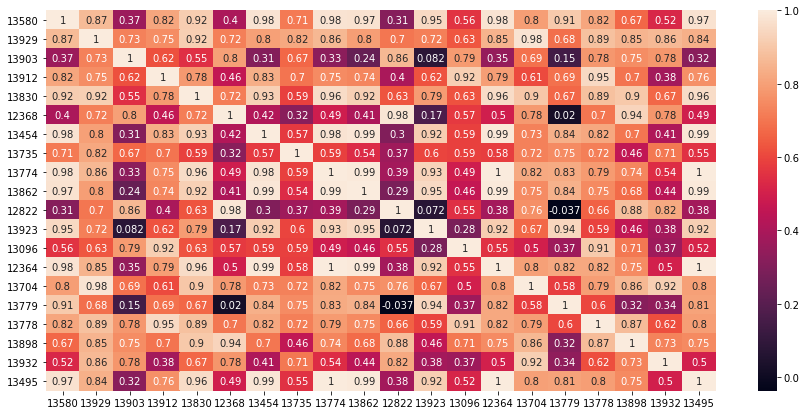

In [58]:

plt.figure(figsize=(15,7))
df_recommendation.corr()
sn.heatmap(df_recommendation.corr().iloc[:20,:20], annot=True)
plt.show()

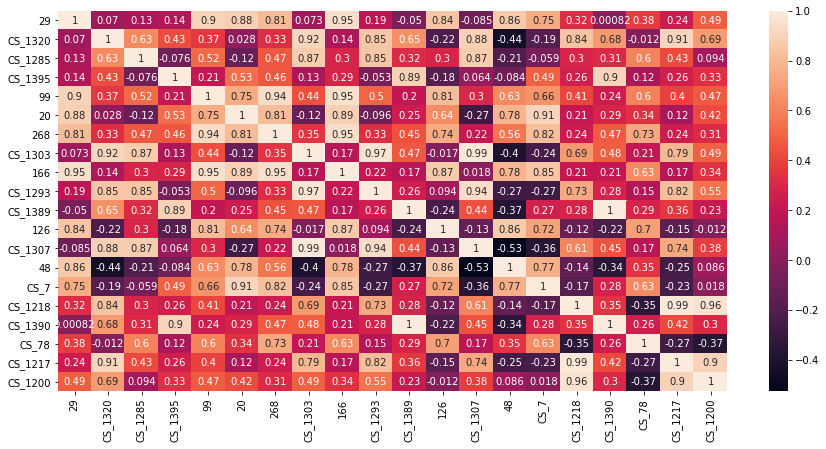

In [59]:


plt.figure(figsize=(15,7))
df_recommendation.corr()
sn.heatmap(df_recommendation.T.corr().iloc[:20,:20], annot=True)
plt.show()

## References  
<a id = "Reference"></a>
1) [Andrew Ng](https://www.youtube.com/playlist?list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN)